In [21]:
from sklearn.model_selection import train_test_split
import transformers
from transformers import DistilBertTokenizer, DistilBertConfig
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, AutoTokenizer 
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os

In [22]:
import tensorflow as tf
tf.config.list_logical_devices("GPU")

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [23]:
print(transformers.__version__)

4.48.0


In [24]:
root_path = '../bbc-text.csv'

In [25]:
df = pd.read_csv(root_path)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [26]:
df.shape

(2225, 2)

In [27]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [28]:
df['encoded_text'] = df['category'].astype('category').cat.codes

df.head(10)

,category,text,encoded_text
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0
2,sport,tigers wary of farrell gamble leicester say ...,3
3,sport,yeading face newcastle in fa cup premiership s...,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,1
5,politics,howard hits back at mongrel jibe michael howar...,2
6,politics,blair prepares to name poll date tony blair is...,2
7,sport,henman hopes ended in dubai third seed tim hen...,3
8,sport,wilkinson fit to face edinburgh england captai...,3
9,entertainment,last star wars not for children the sixth an...,1


### Fine-tuning

In [29]:
# Control the overfitting with dropout probability
# The num_hidden_layers must be equal to 'len(model.layers)', otherwiese the custom_config wont work

custom_config = DistilBertConfig.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=5,
    hidden_size=768,
    num_hidden_layers=4,
    intermediate_size=3072, # default is 3072
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

In [30]:
# Load tokenizer and model
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased",
                                                              config=custom_config,
                                                            #num_labels=5
                                                            )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['distilbert.transformer.layer.5.sa_layer_norm.weight', 'vocab_transform.weight', 'distilbert.transformer.layer.5.attention.out_lin.bias', 'distilbert.transformer.layer.4.attention.q_lin.weight', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.out_lin.weight', 'distilbert.transformer.layer.5.ffn.lin2.weight', 'distilbert.transformer.layer.5.ffn.lin1.bias', 'distilbert.transformer.layer.5.ffn.lin1.weight', 'vocab_transform.bias', 'distilbert.transformer.layer.5.attention.v_lin.weight', 'distilbert.transformer.layer.4.attention.v_lin.bias', 'distilbert.transformer.layer.4.output_layer_norm.weight', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.5.attention.k_lin.weight', 'distilbert.transformer.layer.5.attention.q_lin.weight', 'voc

In [11]:
# Control the Overfitting with freezing some layers
# num_layers = 2

# for layer in model.layers[:num_layers]: # first two layers
#     layer.trainable = False
# for layer in model.layers[num_layers:]: # two last layers
#     layer.trainable = True

In [31]:
# The num_layer
len(model.layers)

4

In [32]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  120558336 
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_27 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 121152773 (462.16 MB)
Trainable params: 121152773 (462.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Load Data

In [33]:
data_texts = df['text'].to_list()
data_labels = df['encoded_text'].to_list()

train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )

In [34]:
# Define the input pipelines
max_length = 128
batch_size = 32

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(batch_size)

In [35]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [36]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [37]:
log_dir = "logs/fit"

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
# if no improvment in 10 epoch then restore the best weights
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [38]:

with tf.device("/GPU:0"):
    history = model.fit(
        train_dataset, 
        validation_data=val_dataset, 
        epochs=20, 
        callbacks=[tensorboard_callback, early_stopping]    
    )

model.save_pretrained("./results")

Epoch 1/20
56/56 [==============================] - 13s 123ms/step - loss: 1.1787 - sparse_categorical_accuracy: 0.6390 - val_loss: 0.3503 - val_sparse_categorical_accuracy: 0.9303
Epoch 2/20
56/56 [==============================] - 6s 107ms/step - loss: 0.2443 - sparse_categorical_accuracy: 0.9421 - val_loss: 0.1603 - val_sparse_categorical_accuracy: 0.9461
Epoch 3/20
56/56 [==============================] - 6s 107ms/step - loss: 0.0991 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.1170 - val_sparse_categorical_accuracy: 0.9640
Epoch 4/20
56/56 [==============================] - 6s 106ms/step - loss: 0.0556 - sparse_categorical_accuracy: 0.9892 - val_loss: 0.1122 - val_sparse_categorical_accuracy: 0.9663
Epoch 5/20
56/56 [==============================] - 6s 104ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.1295 - val_sparse_categorical_accuracy: 0.9663
Epoch 6/20
56/56 [==============================] - 6s 104ms/step - loss: 0.0312 - sparse_categoric

### plotting Loss and accuracy

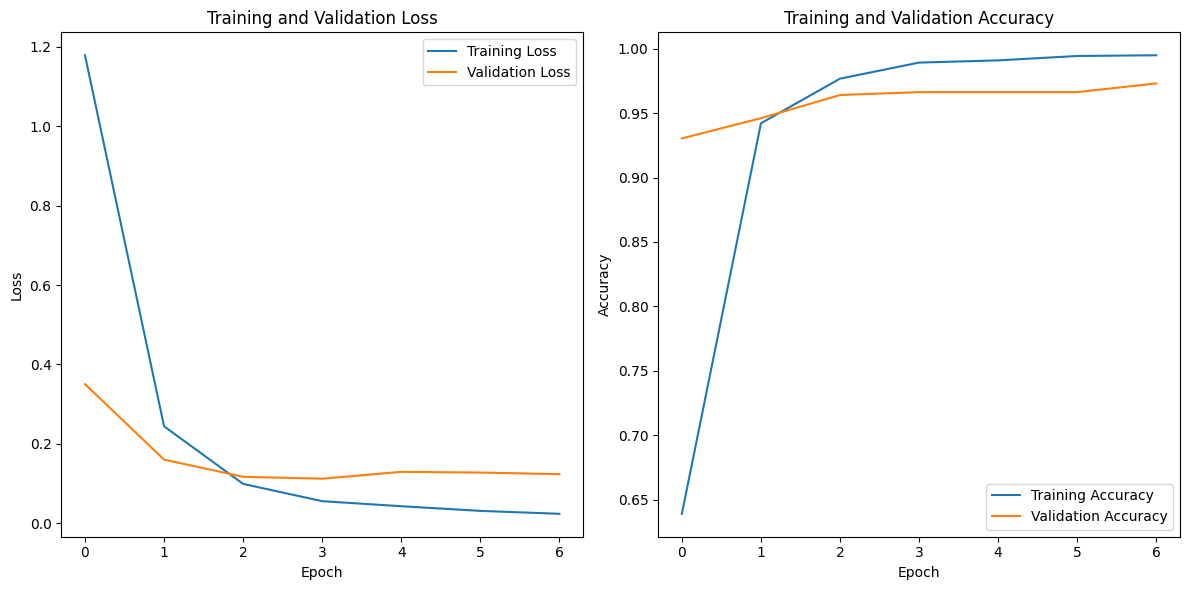

In [39]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [40]:
tokenizer.save_pretrained("./results")

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.txt',
 './results/added_tokens.json',
 './results/tokenizer.json')

In [41]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Loss", test_loss)
print("Test Accuracy", test_accuracy)

1/1 [==============================] - 0s 29ms/step - loss: 0.0272 - sparse_categorical_accuracy: 1.0000
Test Loss 0.0271715447306633
Test Accuracy 1.0


### Loading the pretrained model

In [42]:
# Load tokenizer and model
tokenizer_fine_tuned = AutoTokenizer.from_pretrained("./results")
model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained("./results")


Some layers from the model checkpoint at ./results were not used when initializing TFDistilBertForSequenceClassification: ['dropout_27']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./results and are newly initialized: ['dropout_41']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
test_text = test_texts[5]

In [44]:
test_text

'blair stresses prosperity goals tony blair says his party s next manifesto will be  unremittingly new labour  and aimed at producing  personal prosperity for all .  the prime minister is trying to draw a line under speculation over the state of his relationship with gordon brown with the speech in chatham  kent. he is saying that prosperity means both individual wealth and ensuring  radically improved  public services. he is also claiming labour is more ideologically united than ever. mr brown is currently touring africa after a week of facing questions about reports of his splits with downing street.  with the election widely predicted for may  angry labour mps this week warned mr blair and mr brown about the dangers of disunity. now mr blair is trying to put the focus on the substance of labour s platform for a third term in government. labour made low inflation  unemployment and mortgage rates the centrepiece of a new poster campaign this week.  and on thursday mr blair is saying: 

In [45]:
encoding = tokenizer_fine_tuned(test_text, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [46]:
logits = model_fine_tuned(**encoding).logits

In [47]:
predicted_class = tf.argmax(logits, axis=-1).numpy()[0]
print("predicted_class:", predicted_class)

predicted_class: 2


In [48]:
test_labels[5]

2

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint_callback = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)